In [24]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import astropy
from astropy import stats
import math

import scipy
from scipy import stats

from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
                   arange, sort, amin, amax, atleast_1d, sqrt, array,
                   compress, pi, exp, ravel, count_nonzero, sin, cos,
                   arctan2, hypot)


from scipy import optimize
from scipy import special

import figurefirst as fifi
import time

import metpy
from metpy import calc

# Step 1: Calculate max change at various lags

In [2]:
def maxchange_std (df, startval, lagarray, method='forward'):
    
    d_list=np.zeros((len(lagarray)))
    j=0
    
    def checkforwardbounds(df,startval,lag):
        if (startval+i)>=len(df):
            raise ValueError('Lag value extends beyond length of timeseries')            
    
    def checkbackwardbounds(df,startval,lag):
        if (startval-i)<0:
            raise ValueError('Lag value extends beyond length of timeseries')  

    
    for i in lagarray:
        
        if method=='forward':
            checkforwardbounds(df,startval,i)
            b=df.iloc[startval:startval+i]
            std= mycircstd(b, high=360, low=0) 
            d_list[j]=std
                
        j+=1
    return d_list

In [59]:
def _circfuncs_common(samples, high, low, nan_policy='propagate'):
    # Ensure samples are array-like and size is not zero
    samples = np.asarray(samples)
    if samples.size == 0:
        return np.nan, np.asarray(np.nan), np.asarray(np.nan), None

    # Recast samples as radians that range between 0 and 2 pi and calculate
    # the sine and cosine
    sin_samp = sin((samples - low)*2.*pi / (high - low))
    cos_samp = cos((samples - low)*2.*pi / (high - low))
    #sin_samp=sin(samples)
    #cos_samp=cos(samples)
    mask = None
    return samples, sin_samp, cos_samp, mask


def mycircstd(samples, high=360, low=0, axis=None, nan_policy='propagate'):

    samples, sin_samp, cos_samp, mask = _circfuncs_common(samples, high, low,
                                                          nan_policy=nan_policy)
    if mask is None:
        sin_mean = sin_samp.mean(axis=axis)  # [1] (2.2.3)
        cos_mean = cos_samp.mean(axis=axis)  # [1] (2.2.3)
    else:
        nsum = np.asarray(np.sum(~mask, axis=axis).astype(float))
        nsum[nsum == 0] = np.nan
        sin_mean = sin_samp.sum(axis=axis) / nsum
        cos_mean = cos_samp.sum(axis=axis) / nsum
    # hypot can go slightly above 1 due to rounding errors
    with np.errstate(invalid='ignore'):
        R = np.minimum(1, hypot(sin_mean, cos_mean))  # [1] (2.2.4)

    #res = sqrt(-2*log(R))
    #if not normalize:
    #    res *= (high-low)/(2.*pi)  # [1] (2.3.14) w/ (2.3.7)
    res = np.sqrt(2 * (1 -R))
    
    return res

def maxchange_std (df, startval, lagarray, method='forward'):
    
    d_list=np.zeros((len(lagarray)))
    j=0
    
    def checkforwardbounds(df,startval,lag):
        if (startval+i)>=len(df):
            raise ValueError('Lag value extends beyond length of timeseries')            
    
    def checkbackwardbounds(df,startval,lag):
        if (startval-i)<0:
            raise ValueError('Lag value extends beyond length of timeseries')  

    
    for i in lagarray:
        
        if method=='forward':
            checkforwardbounds(df,startval,i)
            b=df.iloc[startval:startval+i]
            std= mycircstd(b, high=360, low=0) 
            d_list[j]=std
                
        j+=1
    return d_list


def vert_temporal_analysis (vertical_vel, ucomp, vcomp, horizontal_speed, horizontal_dir, lagarray, method='forward'):
    '''
# This function takes a single starting value from a column of directional data in a pandas df or np array
# and returns a list of values at each desired lag.

# Note, directional data must be between 0-360 degrees.
# Need to convert data if in radians and/or if it goes from -180 to 180.


#inputs: df - one column or array of directional data bounded between 0-360
#        startval - first point of wind data that you want to analyze
#        lagarray - array of time lags that you wish to calculate. a lag of 1=.1 sec
#        method - time direction in which lags are calculated 
#        options are forward, backward, average, max, or min. 
#             if no method is selected, forward is the default
    '''
    
    avg_vertical_vel_list=np.zeros((len(lagarray)))
    avg_horizontal_speed_list=np.zeros((len(lagarray)))
    avg_horizontal_dir_list=np.zeros((len(lagarray)))
    
    std_vertical_vel_list=np.zeros((len(lagarray)))
    std_horizontal_speed_list=np.zeros((len(lagarray)))
    std_horizontal_dir_list=np.zeros((len(lagarray)))
    
    frictional_vel_list=np.zeros((len(lagarray)))
    j=0

    def fixangle(angle):
        if angle>=180:
            angle=360-angle
        return angle
    
    
    def checkforwardbounds(dir_df,startval,lag): 
    #compute the standard deviation backwards if the start value+lag will be greater than the length of the df
        if (startval+i)>=len(df): 
            
            vertchunk=vertical_vel.iloc[(startval-i):startval]
            horizontalchunk=horizontal_speed.iloc[(startval-i):startval]
            dirchunk=horizontal_dir.iloc[(startval-i):startval]
            uchunk=ucomp.iloc[(startval-i):startval]
            vchunk=vcomp.iloc[(startval-i):startval]
            
            avg_vertical_vel_list[j]= np.mean(vertchunk)
            avg_horizontal_speed_list[j]= np.mean(horizontalchunk)
            avg_horizontal_dir_list[j]=scipy.stats.circmean(dirchunk,high=360, low=0)
            
            std_vertical_vel_list[j]= np.std(vertchunk)
            std_horizontal_speed_list[j]=np.std(horizontalchunk)
            std_horizontal_dir_list[j]=mycircstd(dirchunk, high=360, low=0)
            frictional_vel_list[j]= metpy.calc.friction_velocity(u=uchunk,v=vchunk,w=vertchunk, axis=0)   
    
    for i in lagarray:
        
        if method=='forward': #currently only forward - will eventually update?
            startval=int(vertical_vel.sample(1).index.to_numpy()) #get a random start value for each lag
            checkforwardbounds(vertical_vel,startval,i)
            vertchunk=vertical_vel.iloc[startval:(startval+i)]
            horizontalchunk=horizontal_speed.iloc[startval:(startval+i)]
            dirchunk=horizontal_dir.iloc[startval:(startval+i)]
            uchunk=ucomp.iloc[startval:(startval+i)]
            vchunk=vcomp.iloc[startval:(startval+i)]
            
            avg_vertical_vel_list[j]= np.mean(vertchunk)
            avg_horizontal_speed_list[j]= np.mean(horizontalchunk)
            avg_horizontal_dir_list[j]=scipy.stats.circmean(dirchunk,high=360, low=0)
            
            std_vertical_vel_list[j]= np.std(vertchunk)
            std_horizontal_speed_list[j]=np.std(horizontalchunk)
            std_horizontal_dir_list[j]=mycircstd(dirchunk, high=360, low=0) 
            frictional_vel_list[j]= metpy.calc.friction_velocity(u=uchunk,v=vchunk,w=vertchunk, axis=0)  
            
        j+=1
    #return uchunk, vchunk
    return avg_vertical_vel_list, avg_horizontal_speed_list, avg_horizontal_dir_list, std_vertical_vel_list,std_horizontal_speed_list,std_horizontal_dir_list, frictional_vel_list

In [ ]:
df1=pd.read_hdf('small_10.20.20_maskedgpsdata.hdf')
df2=pd.read_hdf('small_7.7.21_maskedgpsdata.hdf')
df3=pd.read_hdf('small_9.26.21_maskedgpsdata.hdf')
df4=pd.read_hdf('small_10.29.21_maskedgpsdata.hdf')
df5=pd.read_hdf('small_10.30.21_maskedgpsdata.hdf')
df6=pd.read_hdf('small_1.8.22_maskedgpsdata.hdf')
df7=pd.read_hdf('small_1.11.22_maskedgpsdata.hdf')
df8=pd.read_hdf('small_1.15.22_maskedgpsdata.hdf')
df9=pd.read_hdf('small_4.30.22_maskedgpsdata.hdf')
df10=pd.read_hdf('small_5.1.22_maskedgpsdata.hdf')
df11=pd.read_hdf('small_5.2.22_maskedgpsdata.hdf')
df12=pd.read_hdf('small_6.1.22_maskedgpsdata.hdf')
df13=pd.read_hdf('small_6.3.22_maskedgpsdata.hdf')
df14=pd.read_hdf('small_6.7.22_maskedgpsdata.hdf')
df15=pd.read_hdf('small_6.8.22_maskedgpsdata.hdf')
df16=pd.read_hdf('small_6.22.22_maskedgpsdata.hdf')

In [7]:
df1=pd.read_hdf('bigfiles/10.20.20_all.hdf')
df2=pd.read_hdf('bigfiles/7.7.21_all.hdf')
df3=pd.read_hdf('bigfiles/9.26.21_all.hdf')
df4=pd.read_hdf('bigfiles/10.29.21_all.hdf')
df5=pd.read_hdf('bigfiles/10.30.21_all.hdf')
df6=pd.read_hdf('bigfiles/1.8.22_all.hdf')
df7=pd.read_hdf('bigfiles/1.11.22_all.hdf')
df8=pd.read_hdf('bigfiles/1.15.22_all.hdf')
df9=pd.read_hdf('bigfiles/4.30.22_all.hdf')
df10=pd.read_hdf('bigfiles/5.1.22_all.hdf')
df11=pd.read_hdf('bigfiles/5.2.22_all.hdf')
df12=pd.read_hdf('bigfiles/6.1.22_all.hdf')
df13=pd.read_hdf('bigfiles/6.3.22_all.hdf')
df14=pd.read_hdf('bigfiles/6.7.22_all.hdf')
df15=pd.read_hdf('bigfiles/6.8.22_all.hdf')
df16=pd.read_hdf('bigfiles/6.22.22_all.hdf')

# Calculate lags and make a df for each data collection

In [291]:
df=df16.fillna(0)
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(df.time.iloc[0]))

'2022-06-22 11:33:23'

In [255]:
print(df.keys())

Index(['millis_2', 'lat_2', 'lon_2', 'gps_time_2', 'gps_date_2', 'wind_2',
       'gps_date_str_2', 'year_2', 'month_2', 'day_2',
       ...
       'Z_6', 'X_7', 'Y_7', 'Z_7', 'X_8', 'Y_8', 'Z_8',
       'X_9_verticallyorientated', 'Y_9_verticallyorientated',
       'Z_9_verticallyorientated'],
      dtype='object', length=162)


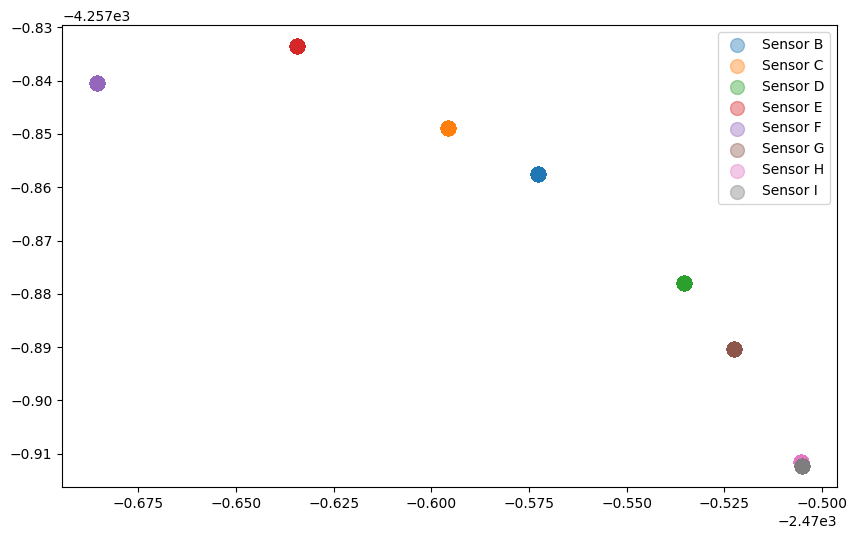

In [292]:
#get a sense of where sensors were located
#vertically oriented sensors were paired on a tripod with another sensor
#using this to determine which sensor to use for horizontal speed comparison
fig=plt.figure(figsize=(10,6))
#plt.scatter(df.X_1,df.Y_1, s=100, alpha=.4, label='Sensor A')
plt.scatter(df.X_2,df.Y_2, s=100, alpha=.4, label='Sensor B')
plt.scatter(df.X_3,df.Y_3, s=100, alpha=.4, label='Sensor C')
plt.scatter(df.X_4_verticallyorientated,df.Y_4_verticallyorientated, s=100, alpha=.4, label='Sensor D')
plt.scatter(df.X_5,df.Y_5, s=100, alpha=.4, label='Sensor E')
plt.scatter(df.X_6,df.Y_6, s=100, alpha=.4, label='Sensor F')
plt.scatter(df.X_7,df.Y_7, s=100, alpha=.4, label='Sensor G')
plt.scatter(df.X_8,df.Y_8, s=100, alpha=.4, label='Sensor H')
plt.scatter(df.X_9_verticallyorientated,df.Y_9_verticallyorientated, s=100, alpha=.4, label='Sensor I')
plt.legend()

In [293]:
loglags= array([100, 300,  600,  900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300,
       3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000])

In [294]:
#loglags=np.arange(300,6300,300) #lags from 0-10mins, 30 sec intervals -- excluding lag zero since there is no standard dev over a period of 0

loglags= array([100, 300,  600,  900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000])

totalrows=np.arange(0,int(len(df)/10000))

avg_vert_U = np.empty((len(totalrows), 0)).tolist()
avg_s2 = np.empty((len(totalrows), 0)).tolist()
avg_d = np.empty((len(totalrows), 0)).tolist()
std_vert_U = np.empty((len(totalrows), 0)).tolist()
std_s2 = np.empty((len(totalrows), 0)).tolist()
std_d= np.empty((len(totalrows), 0)).tolist()
frictionalvel= np.empty((len(totalrows), 0)).tolist()

In [295]:
i=0
for j in totalrows:
    avg_vert_U[i], avg_s2[i], avg_d[i], std_vert_U[i], std_s2[i], std_d[i], frictionalvel[i] = vert_temporal_analysis(df.U_9_verticallyorientated,  df.U_8,  df.V_8, df.S2_8, df.D_8, lagarray=loglags, method='forward')
    i=i+1

In [296]:
#convert to df
df_avg_U=pd.DataFrame(avg_vert_U, index=range(len(avg_vert_U)), columns=loglags)
df_avg_s2=pd.DataFrame(avg_s2, index=range(len(avg_s2)), columns=loglags)
df_avg_d=pd.DataFrame(avg_d, index=range(len(avg_d)), columns=loglags)

df_std_U=pd.DataFrame(std_vert_U, index=range(len(std_vert_U)), columns=loglags)
df_std_s2=pd.DataFrame(std_s2, index=range(len(std_s2)), columns=loglags)
df_std_d=pd.DataFrame(std_d, index=range(len(std_d)), columns=loglags)

df_frictionalvel=pd.DataFrame(frictionalvel, index=range(len(frictionalvel)), columns=loglags)

In [297]:
full_df=pd.DataFrame(columns = ['frictional_vel', 'vert_vel_avg','horizontal_speed_avg', 'horizontal_dir_avg','vert_vel_std','horizontal_speed_std', 'horizontal_dir_std'])

i=0


for k in df_avg_U.index:
    xtra = {'vert_vel_avg': df_avg_U.iloc[k,:], 
           'horizontal_speed_avg': df_avg_s2.iloc[k,:],
           'horizontal_dir_avg': df_avg_d.iloc[k,:],
            
           'vert_vel_std' :df_std_U.iloc[k,:],
            'horizontal_speed_std': df_std_s2.iloc[k,:],
           'horizontal_dir_std': df_std_d.iloc[k,:],
            'frictional_vel': df_frictionalvel.iloc[k,:],
            }
    full_df= full_df.append(pd.DataFrame(xtra))
i=i+1

/tmp/ipykernel_349144/484960843.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df= full_df.append(pd.DataFrame(xtra))
/tmp/ipykernel_349144/484960843.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df= full_df.append(pd.DataFrame(xtra))
/tmp/ipykernel_349144/484960843.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df= full_df.append(pd.DataFrame(xtra))
/tmp/ipykernel_349144/484960843.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df= full_df.append(pd.DataFrame(xtra))
/tmp/ipykernel_349144/484960843.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

In [298]:
full_df

,frictional_vel,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std
100,0.341600,1.899600,1.608100,83.374298,0.356763,0.296799,0.294075
300,0.162378,-0.259833,1.877567,233.854371,0.254273,0.293988,0.211761
600,0.304707,0.328083,1.422933,298.013570,0.674010,0.404406,0.355793
900,0.263389,1.799489,1.461578,59.158868,0.367990,0.463022,0.308658
1200,0.577924,0.501142,0.989517,169.511155,0.619894,0.529902,0.763194
...,...,...,...,...,...,...,...
4800,0.618961,1.075298,1.196556,108.138702,0.678914,0.584649,0.855775
5100,0.772457,1.068016,1.239808,81.441376,0.766678,0.714118,1.214447
5400,0.705305,0.830443,1.172765,132.994512,0.738561,0.592950,1.218364
5700,0.606414,0.926854,1.278093,136.441617,0.742191,0.572589,0.777312


In [299]:
full_df.reset_index(inplace=True)
full_df.rename(columns={'index':'time'}, inplace=True)

In [300]:
full_df[['environment']]=.4
full_df[['group']]=16
full_df.horizontal_dir_std=full_df.horizontal_dir_std*180/np.pi #make it degrees again
full_df.time=full_df.time*.1 #fix the time to be accurate 
full_df['cos_horizontal_dir_avg']=np.cos(full_df.horizontal_dir_avg*np.pi/180)
full_df['sin_horizontal_dir_avg']=np.sin(full_df.horizontal_dir_avg*np.pi/180)
full_df['normed_vert_vel']=full_df.vert_vel_std/full_df.frictional_vel
full_df['turbulent_intensity']=full_df.horizontal_speed_std/full_df.horizontal_speed_avg

In [301]:
full_df

,time,frictional_vel,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std,environment,group,cos_horizontal_dir_avg,sin_horizontal_dir_avg,normed_vert_vel,turbulent_intensity
0,10.0,0.341600,1.899600,1.608100,83.374298,0.356763,0.296799,16.849253,0.4,16,0.115383,0.993321,1.044388,0.184565
1,30.0,0.162378,-0.259833,1.877567,233.854371,0.254273,0.293988,12.132990,0.4,16,-0.589840,-0.807520,1.565934,0.156579
2,60.0,0.304707,0.328083,1.422933,298.013570,0.674010,0.404406,20.385433,0.4,16,0.469681,-0.882836,2.211996,0.284206
3,90.0,0.263389,1.799489,1.461578,59.158868,0.367990,0.463022,17.684802,0.4,16,0.512659,0.858592,1.397135,0.316796
4,120.0,0.577924,0.501142,0.989517,169.511155,0.619894,0.529902,43.727782,0.4,16,-0.983290,0.182044,1.072622,0.535516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,480.0,0.618961,1.075298,1.196556,108.138702,0.678914,0.584649,49.032293,0.4,16,-0.311318,0.950306,1.096862,0.488610
248,510.0,0.772457,1.068016,1.239808,81.441376,0.766678,0.714118,69.582661,0.4,16,0.148821,0.988864,0.992519,0.575991
249,540.0,0.705305,0.830443,1.172765,132.994512,0.738561,0.592950,69.807101,0.4,16,-0.681928,0.731419,1.047151,0.505600
250,570.0,0.606414,0.926854,1.278093,136.441617,0.742191,0.572589,44.536718,0.4,16,-0.724673,0.689093,1.223902,0.448002


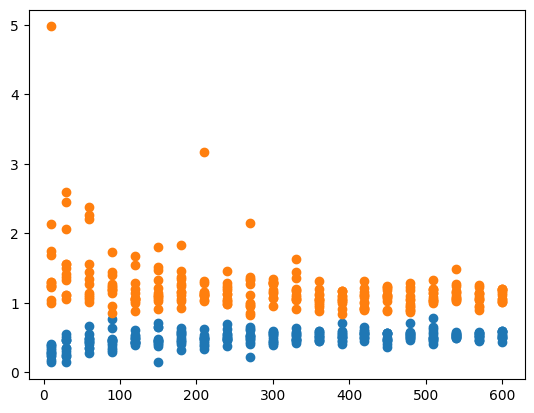

In [302]:
plt.scatter(full_df.time,full_df.turbulent_intensity)
plt.scatter(full_df.time,full_df.normed_vert_vel)

In [303]:
full_df.to_hdf('dataframes_vertical/6.22.22_verticaltemporal.hdf', key='/windgps')

# Looking at all lagged dataframes

In [304]:
#t1=pd.read_hdf('10.20.20_verticaltemporal.hdf') # no vertical sensors in this dataset
t2=pd.read_hdf('dataframes_vertical/7.7.21_verticaltemporal.hdf')
t3=pd.read_hdf('dataframes_vertical/9.26.21_verticaltemporal.hdf')
t4=pd.read_hdf('dataframes_vertical/10.29.21_verticaltemporal.hdf')
t5=pd.read_hdf('dataframes_vertical/10.30.21_verticaltemporal.hdf')
t6=pd.read_hdf('dataframes_vertical/1.8.22_verticaltemporal.hdf')
t7=pd.read_hdf('dataframes_vertical/1.11.22_verticaltemporal.hdf')
t8=pd.read_hdf('dataframes_vertical/1.15.22_verticaltemporal.hdf')
t9=pd.read_hdf('dataframes_vertical/4.30.22_verticaltemporal.hdf')
t10=pd.read_hdf('dataframes_vertical/5.1.22_verticaltemporal.hdf')
t11=pd.read_hdf('dataframes_vertical/5.2.22_verticaltemporal.hdf')
t12=pd.read_hdf('dataframes_vertical/6.1.22_verticaltemporal.hdf')
t13=pd.read_hdf('dataframes_vertical/6.3.22_verticaltemporal.hdf')
t14=pd.read_hdf('dataframes_vertical/6.7.22_verticaltemporal.hdf')
t15=pd.read_hdf('dataframes_vertical/6.8.22_verticaltemporal.hdf')
t16=pd.read_hdf('dataframes_vertical/6.22.22_verticaltemporal.hdf')

In [305]:
alltemp=[t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16]

In [306]:
for i in range(0,15):
    alltemp[i]['vert_turb_intensity']=alltemp[i]['vert_vel_std']/np.abs(alltemp[i]['horizontal_speed_avg'])

In [328]:
for i in range(0,15):
    alltemp[i]['vert_S2_ratio']=np.abs(alltemp[i]['vert_vel_avg'])/alltemp[i]['horizontal_speed_avg']

In [329]:
alltempconcat=pd.concat(alltemp)

In [330]:
alltempconcat=alltempconcat.reset_index(inplace=False)
alltempconcat

,index,time,frictional_vel,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std,environment,group,cos_horizontal_dir_avg,sin_horizontal_dir_avg,normed_vert_vel,turbulent_intensity,vert_turb_intensity,vert_S2_ratio
0,0,10.0,0.386126,0.180630,2.610000,275.650550,0.383615,0.594244,12.535627,0.4,2,0.098461,-0.995141,0.993498,0.227680,0.146979,0.069207
1,1,30.0,0.537392,-0.696263,1.393633,188.274028,0.420321,0.758198,23.796467,0.4,2,-0.989591,-0.143908,0.782149,0.544044,0.301601,0.499603
2,2,60.0,0.993454,-1.175978,3.841000,246.854405,0.964024,0.730120,19.342347,0.4,2,-0.393069,-0.919509,0.970376,0.190086,0.250982,0.306165
3,3,90.0,1.433295,-1.788629,3.025500,163.740794,1.148158,1.392115,42.654989,0.4,2,-0.960005,0.279983,0.801061,0.460127,0.379493,0.591185
4,4,120.0,0.798736,-2.368121,3.732983,206.106332,0.760091,1.171386,19.221117,0.4,2,-0.897979,-0.440038,0.951617,0.313794,0.203615,0.634378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5056,247,480.0,0.618961,1.075298,1.196556,108.138702,0.678914,0.584649,49.032293,0.4,16,-0.311318,0.950306,1.096862,0.488610,0.567390,0.898661
5057,248,510.0,0.772457,1.068016,1.239808,81.441376,0.766678,0.714118,69.582661,0.4,16,0.148821,0.988864,0.992519,0.575991,0.618385,0.861436
5058,249,540.0,0.705305,0.830443,1.172765,132.994512,0.738561,0.592950,69.807101,0.4,16,-0.681928,0.731419,1.047151,0.505600,0.629760,0.708107
5059,250,570.0,0.606414,0.926854,1.278093,136.441617,0.742191,0.572589,44.536718,0.4,16,-0.724673,0.689093,1.223902,0.448002,0.580702,0.725185


## plotting

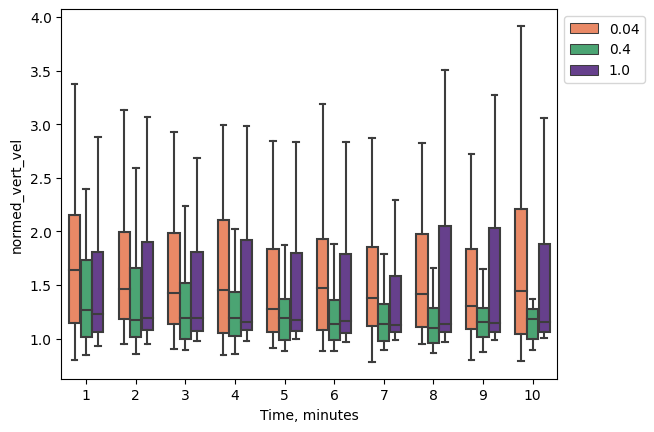

In [312]:
minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
fig, ax = plt.subplots()
sns.boxplot(x='time', y='normed_vert_vel', hue='environment', data=minutesdf, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.7, ax=ax)    
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax.set_xlabel('Time, minutes')
ax.legend(bbox_to_anchor=(1,1))

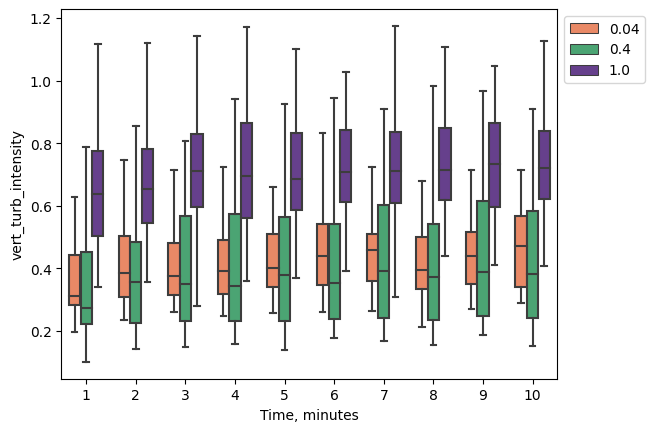

In [311]:
minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
fig, ax = plt.subplots()
sns.boxplot(x='time', y='vert_turb_intensity', hue='environment', data=minutesdf, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.7, ax=ax)    
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax.set_xlabel('Time, minutes')
ax.legend(bbox_to_anchor=(1,1))

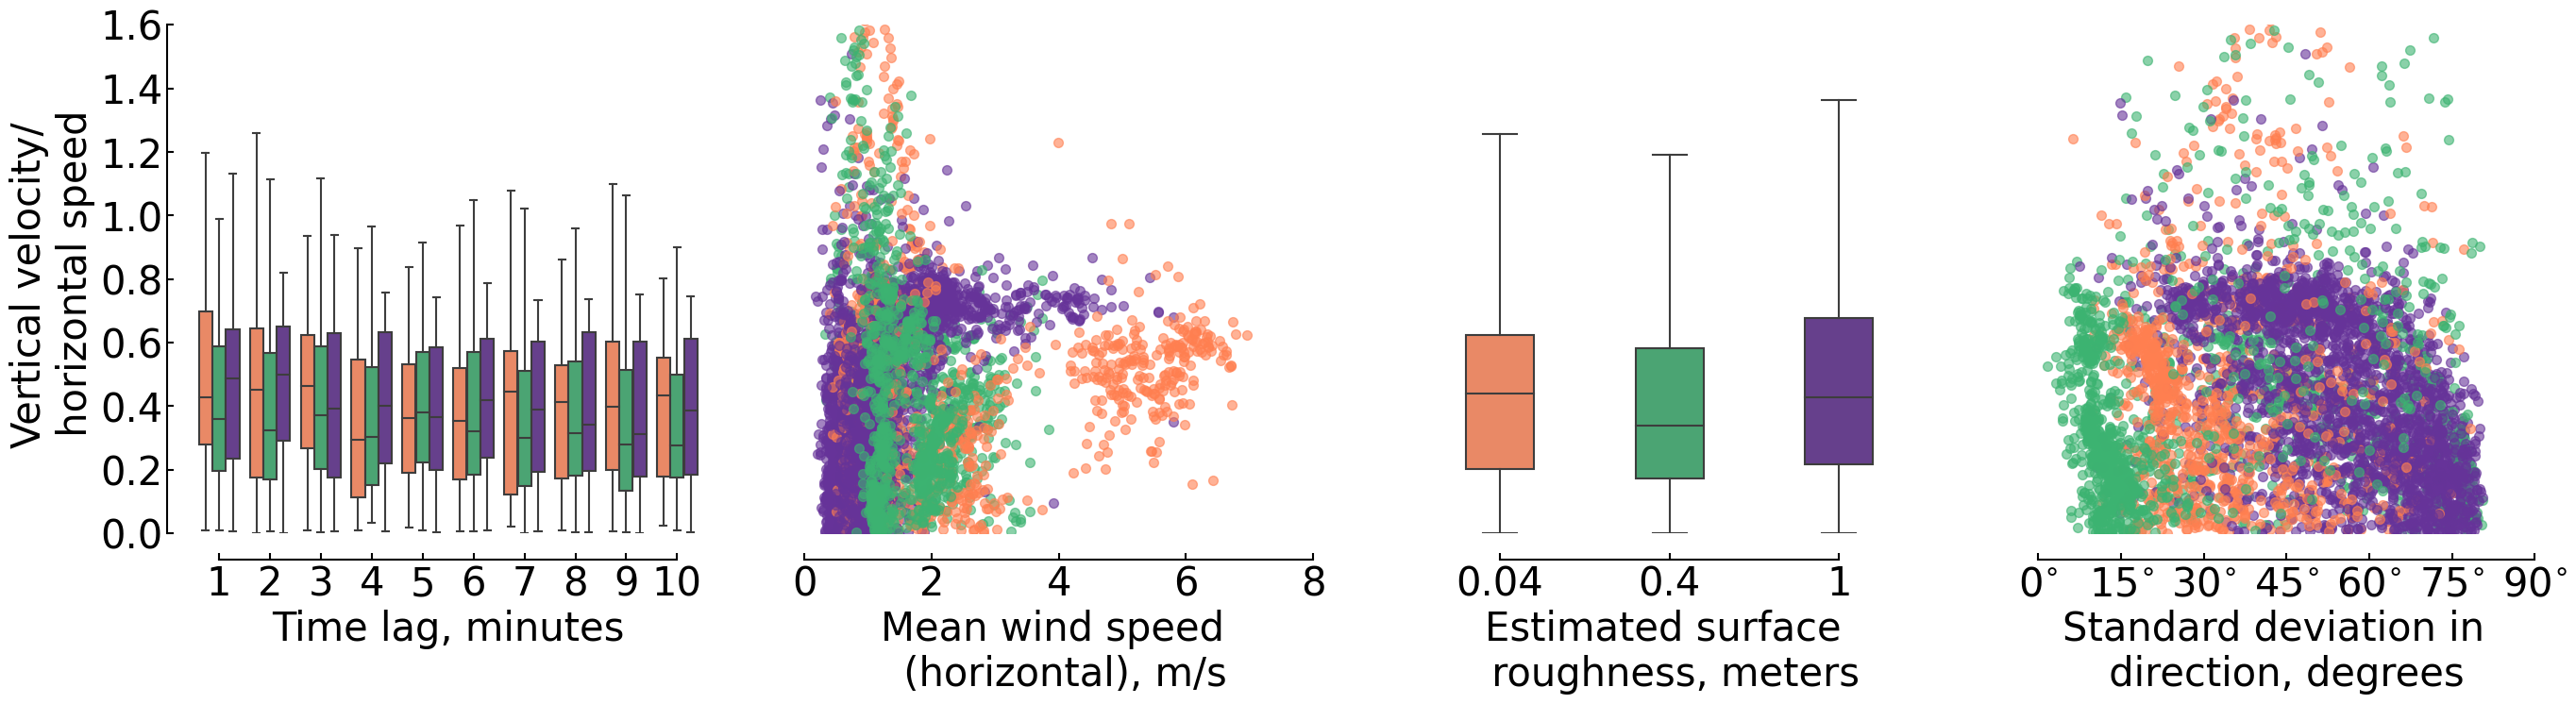

In [366]:
mpl.rcParams.update({'font.size': 30})

c=['mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax =plt.subplots(nrows=1, ncols=4, figsize=(32,7), rasterized=True)
#ax[1].scatter(alltemp[0].horizontal_speed_avg, np.abs(alltemp[0].vert_vel_std),  s=20, color=c[0], alpha=.6, label='desert/valley')
#ax[1].scatter(alltemp[1].horizontal_speed_avg, np.abs(alltemp[1].vert_vel_std),  s=20, color=c[1], alpha=.6, label='forest')
#ax[1].scatter(alltemp[2].horizontal_speed_avg, np.abs(alltemp[2].vert_vel_std),  s=20, color=c[2], alpha=.6, label='urban')

# add mean lines
#ax[1].plot(deserttemp.speed_avg, abline_values_desertdirection3, 'blue', linewidth=5)
#ax[1].plot(foresttemp.speed_avg, abline_values_forestdirection3, 'darkgreen',linewidth=5)
#ax[1].plot(urbantemp.speed_avg, abline_values_urbandirection3, 'indigo', linewidth=5)


for i in range(0,15):
    ax[1].scatter(alltemp[i].horizontal_speed_avg, alltemp[i].vert_S2_ratio,  s=50, color=c[i],alpha=.6)
    ax[3].scatter(alltemp[i].horizontal_dir_std,alltemp[i].vert_S2_ratio,  s=50, color=c[i], alpha=.6)
    
#sns.boxplot(x='time', y='vert_vel_std', hue='environment', data=allt1, showfliers=False, palette=['steelblue', 'seagreen', 'purple',], width=.7, ax=ax[0])    
minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
#minutesdf['abs_ver_vel']=np.abs()
sns.boxplot(x=minutesdf.time, y=minutesdf.vert_S2_ratio, hue=minutesdf.environment, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.8, ax=ax[0])    
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax[0].set_xlabel('Time lags, minutes')
ax[0].legend(bbox_to_anchor=(3,1))

sns.boxplot(x=alltempconcat.environment, y=alltempconcat.vert_S2_ratio, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.4, ax=ax[2])

#xticks=np.arange(0,6300,300)
#ax[0].set_xticklabels(xticks)
ax[2].set_xticklabels([.04, .4, 1])
ax[0].set_ylabel('Vertical velocity/ \n horizontal speed')
ax[0].set_xlabel('Time lag, minutes')  
ax[1].set_xlabel('Mean wind speed \n (horizontal), m/s')
ax[2].set_ylabel('')
ax[3].set_xlabel('Standard deviation in \n direction, degrees')
ax[2].set_xlabel('Estimated surface \n roughness, meters')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)

ax[0].set_ylim(0,1.5)
ax[1].set_ylim(0,1.5)
ax[2].set_ylim(0,1.5)
ax[3].set_ylim(0,1.5)
ax[1].set_xlim(0,7)
# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')


fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=np.arange(0,17,2)/10,
                                 #xticks=[1,100,500,1000],
                                 tick_length=5,
                                 spine_locations={'left': 20, 'bottom': 20},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=5,
                                 spine_locations={'bottom': 20},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=5,
                                 spine_locations={'bottom': 20},
                                 linewidth=1.5)

fifi.mpl_functions.adjust_spines(ax[3], [ 'bottom'],
                                 xticks=[0,15,30,45,60,75,90],
                                 tick_length=5,
                                 spine_locations={ 'bottom': 20},
                                 linewidth=1.5)
evenxticks=np.arange(0, 100, 15)
xticklabels=[['$' + str(x) + '^{\circ}$' + '',] for x in evenxticks]
xticklabels=np.ravel(xticklabels)
ax[3].set_xticklabels(xticklabels)



fig.savefig('regression_verticalratio.svg', bbox_inches='tight', format='svg')


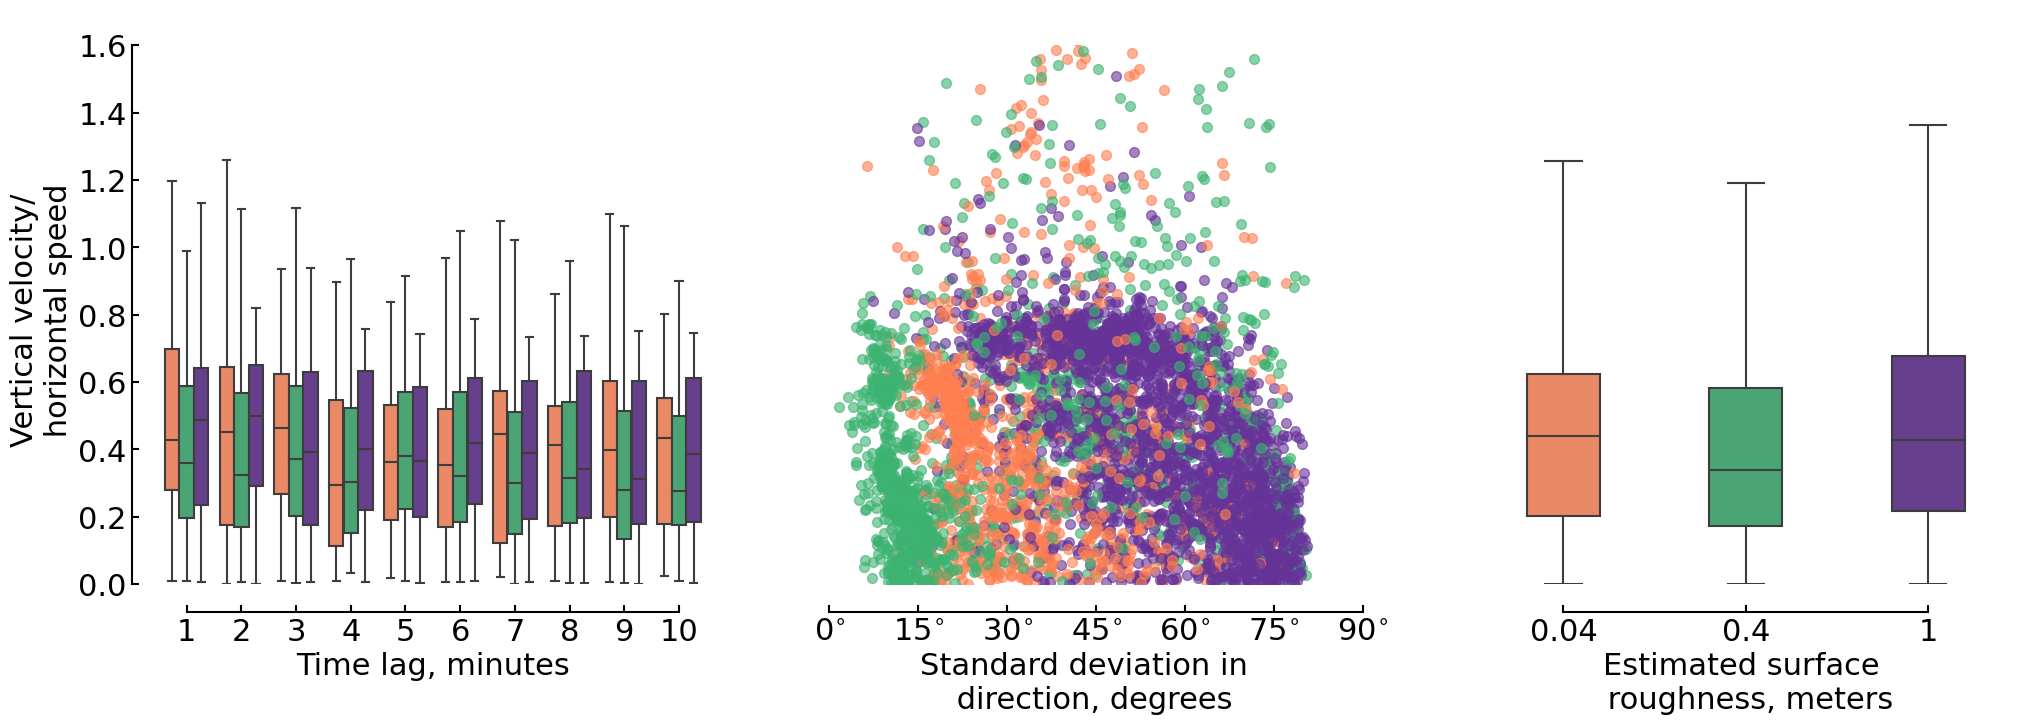

In [365]:
mpl.rcParams.update({'font.size': 22})

c=['mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,7), rasterized=True)
#ax[1].scatter(alltemp[0].horizontal_speed_avg, np.abs(alltemp[0].vert_vel_std),  s=20, color=c[0], alpha=.6, label='desert/valley')
#ax[1].scatter(alltemp[1].horizontal_speed_avg, np.abs(alltemp[1].vert_vel_std),  s=20, color=c[1], alpha=.6, label='forest')
#ax[1].scatter(alltemp[2].horizontal_speed_avg, np.abs(alltemp[2].vert_vel_std),  s=20, color=c[2], alpha=.6, label='urban')

# add mean lines
#ax[1].plot(deserttemp.speed_avg, abline_values_desertdirection3, 'blue', linewidth=5)
#ax[1].plot(foresttemp.speed_avg, abline_values_forestdirection3, 'darkgreen',linewidth=5)
#ax[1].plot(urbantemp.speed_avg, abline_values_urbandirection3, 'indigo', linewidth=5)


for i in range(0,15):
    ax[1].scatter(alltemp[i].horizontal_dir_std,alltemp[i].vert_S2_ratio,  s=50, color=c[i], alpha=.6)
    
#sns.boxplot(x='time', y='vert_vel_std', hue='environment', data=allt1, showfliers=False, palette=['steelblue', 'seagreen', 'purple',], width=.7, ax=ax[0])    
minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
#minutesdf['abs_ver_vel']=np.abs()
sns.boxplot(x=minutesdf.time, y=minutesdf.vert_S2_ratio, hue=minutesdf.environment, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.8, ax=ax[0])    
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax[0].set_xlabel('Time lags, minutes')
ax[0].legend(bbox_to_anchor=(3,1))

sns.boxplot(x=alltempconcat.environment, y=alltempconcat.vert_S2_ratio, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.4, ax=ax[2])

#xticks=np.arange(0,6300,300)
#ax[0].set_xticklabels(xticks)
ax[2].set_xticklabels([.04, .4, 1])
ax[0].set_ylabel('Vertical velocity/ \n horizontal speed')
ax[0].set_xlabel('Time lag, minutes')  
ax[2].set_ylabel('')
ax[1].set_xlabel('Standard deviation in \n direction, degrees')
ax[2].set_xlabel('Estimated surface \n roughness, meters')
ax[0].grid(False)
ax[2].grid(False)
ax[1].grid(False)

ax[0].set_ylim(0,1.5)
ax[2].set_ylim(0,1.5)
ax[1].set_ylim(0,1.5)
# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')


fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=np.arange(0,17,2)/10,
                                 #xticks=[1,100,500,1000],
                                 tick_length=5,
                                 spine_locations={'left': 20, 'bottom': 20},
                                 linewidth=1.5)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=5,
                                 spine_locations={'bottom': 20},
                                 linewidth=1.5)

fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[0,15,30,45,60,75,90],
                                 tick_length=5,
                                 spine_locations={ 'bottom': 20},
                                 linewidth=1.5)
evenxticks=np.arange(0, 100, 15)
xticklabels=[['$' + str(x) + '^{\circ}$' + '',] for x in evenxticks]
xticklabels=np.ravel(xticklabels)
ax[1].set_xticklabels(xticklabels)



fig.savefig('regression_verticalratio_3panel.svg', bbox_inches='tight', format='svg')


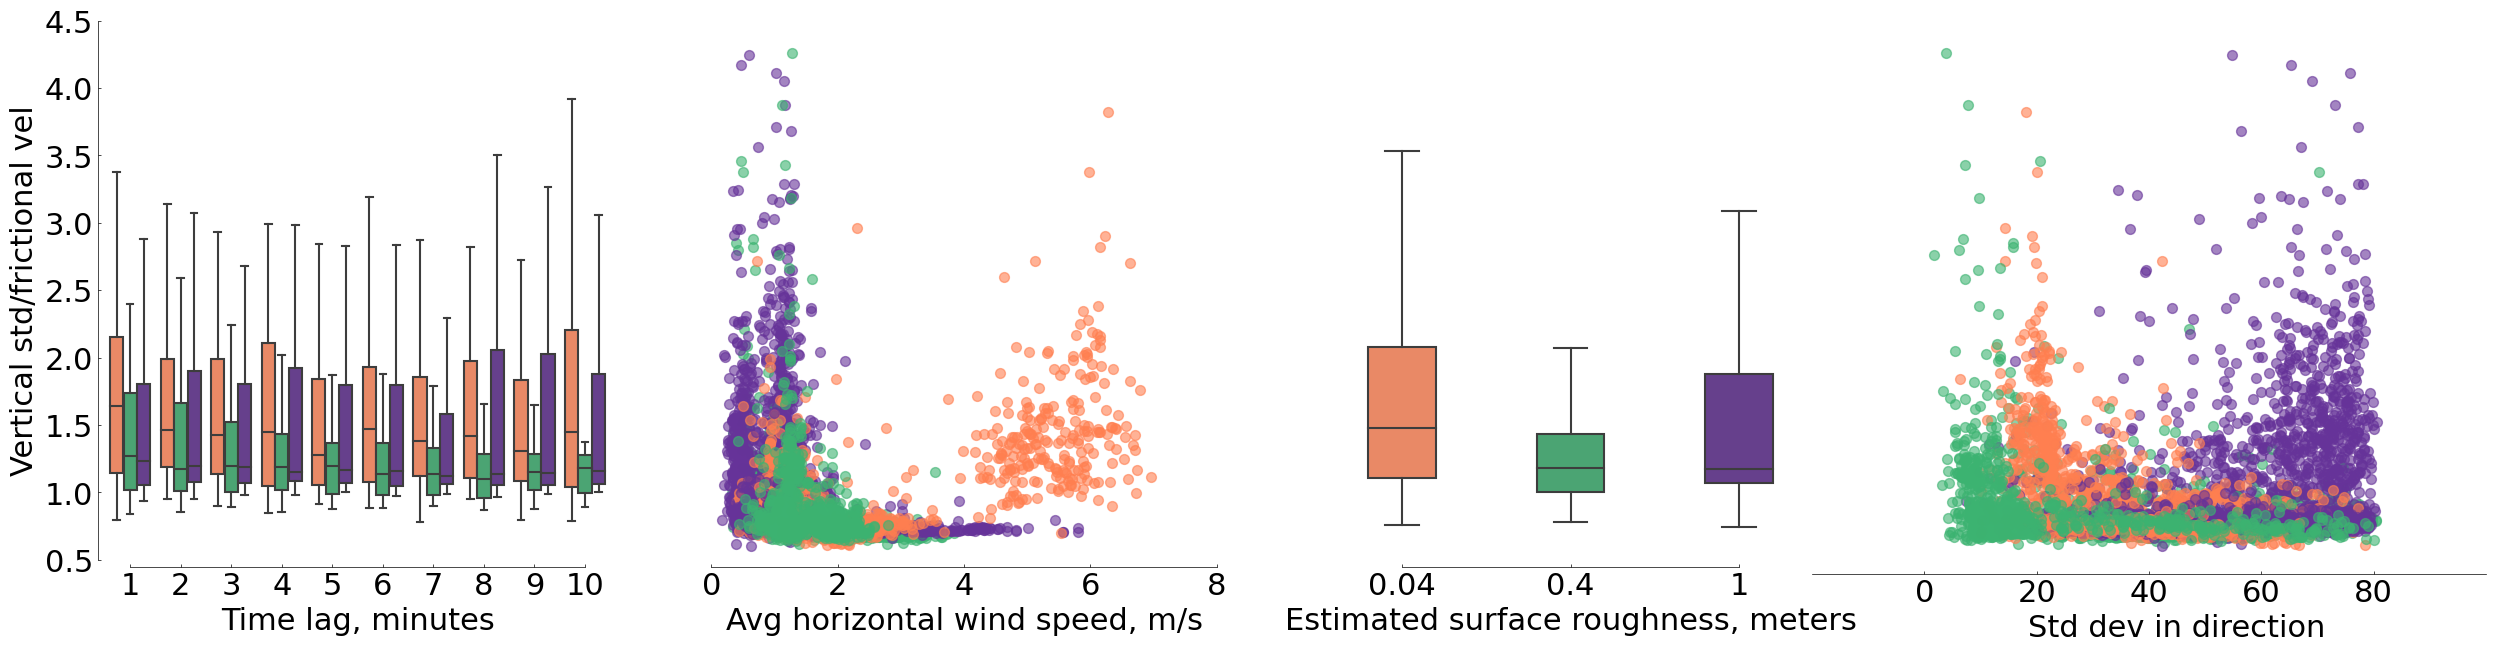

In [342]:
mpl.rcParams.update({'font.size': 22})

c=['mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax =plt.subplots(nrows=1, ncols=4, figsize=(30,7), rasterized=True)
#ax[1].scatter(alltemp[0].horizontal_speed_avg, np.abs(alltemp[0].vert_vel_std),  s=20, color=c[0], alpha=.6, label='desert/valley')
#ax[1].scatter(alltemp[1].horizontal_speed_avg, np.abs(alltemp[1].vert_vel_std),  s=20, color=c[1], alpha=.6, label='forest')
#ax[1].scatter(alltemp[2].horizontal_speed_avg, np.abs(alltemp[2].vert_vel_std),  s=20, color=c[2], alpha=.6, label='urban')

# add mean lines
#ax[1].plot(deserttemp.speed_avg, abline_values_desertdirection3, 'blue', linewidth=5)
#ax[1].plot(foresttemp.speed_avg, abline_values_forestdirection3, 'darkgreen',linewidth=5)
#ax[1].plot(urbantemp.speed_avg, abline_values_urbandirection3, 'indigo', linewidth=5)


for i in range(0,15):
    ax[1].scatter(alltemp[i].horizontal_speed_avg, alltemp[i].normed_vert_vel,  s=50, color=c[i],alpha=.6)
    ax[3].scatter(alltemp[i].horizontal_dir_std,alltemp[i].normed_vert_vel,  s=50, color=c[i], alpha=.6)
    
#sns.boxplot(x='time', y='vert_vel_std', hue='environment', data=allt1, showfliers=False, palette=['steelblue', 'seagreen', 'purple',], width=.7, ax=ax[0])    
minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
#minutesdf['abs_ver_vel']=np.abs()
sns.boxplot(x=minutesdf.time, y=minutesdf.normed_vert_vel, hue=minutesdf.environment, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.8, ax=ax[0])    
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax[0].set_xlabel('Time lags, minutes')
ax[0].legend(bbox_to_anchor=(3,1))

sns.boxplot(x=alltempconcat.environment, y=alltempconcat.normed_vert_vel, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.4, ax=ax[2])

#xticks=np.arange(0,6300,300)
#ax[0].set_xticklabels(xticks)
ax[2].set_xticklabels([.04, .4, 1])
ax[0].set_ylabel('Vertical std/frictional vel')
ax[0].set_xlabel('Time lag, minutes')  
ax[1].set_xlabel('Avg horizontal wind speed, m/s')
ax[2].set_ylabel('')
ax[3].set_xlabel('Std dev in direction')
ax[2].set_xlabel('Estimated surface roughness, meters')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)

ax[0].set_ylim(.5,4.5)
ax[1].set_ylim(.5,10)
ax[2].set_ylim(.5,4.5)
ax[3].set_ylim(.5,10)
ax[1].set_xlim(0,7)
# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')


fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                
                                 #xticks=[1,100,500,1000],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)



# set yticklabels
#evenyticks = np.arange(0, 180+20, 20)
#yticklabels = [['$' + str(y) + '^{\circ}$', ''] for y in evenyticks]
#yticklabels = np.ravel(yticklabels)[0:-1]
#ax[0].set_yticklabels(yticklabels)

fifi.mpl_functions.adjust_spines(ax[3], [ 'bottom'],
                                 
                                 tick_length=2.5,
                                 spine_locations={ 'bottom': 10},
                                 linewidth=0.5)
ax[3].set_xlim(0,90)

fig.savefig('regression_verticalnormed.svg', format='svg')


# Regression analysis

In [ ]:
alltemporal=pd.read_hdf('all_temporal.hdf', key='/windgps')

In [353]:
alltemporal['abs_vert_vel_avg']=np.abs(alltemporal.vert_vel_avg)

In [326]:
alltempconcat['vert_S2_ratio']=alltemporal.vert_vel_avg/alltemporal.horizontal_speed_avg 	

In [315]:
alltemporal=alltempconcat

In [316]:
#normalize pandas columns
N=len(alltemporal)+1
normalized_data = alltemporal.iloc[:,0:N].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(7))

In [317]:
normalized_data

,time,frictional_vel,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std,environment,group,cos_horizontal_dir_avg,sin_horizontal_dir_avg,normed_vert_vel,turbulent_intensity,vert_turb_intensity
0,-1.605716,-0.477238,0.526982,0.907134,0.809191,-0.865417,-0.228502,-1.507666,-0.596504,-1.662988,0.408382,-1.093675,-0.590575,-1.537635,-1.764946
1,-1.495159,-0.089781,-0.393492,-0.150007,-0.182469,-0.779028,0.145943,-0.968061,-0.596504,-1.662988,-1.272466,0.102155,-0.790158,0.336478,-1.103336
2,-1.329322,1.078387,-0.897048,1.976994,0.482376,0.500612,0.081818,-1.181497,-0.596504,-1.662988,-0.350945,-0.987426,-0.612410,-1.760338,-1.319926
3,-1.163486,2.205007,-1.540147,1.268245,-0.460903,0.933982,1.593714,-0.064386,-0.596504,-1.662988,-1.226761,0.697646,-0.772298,-0.160636,-0.770040
4,-0.997650,0.579632,-2.148439,1.883117,0.019915,0.020643,1.089603,-1.187306,-0.596504,-1.662988,-1.130942,-0.313856,-0.630124,-1.027504,-1.522607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.992385,0.119152,1.466114,-0.321286,-1.091946,-0.170411,-0.250416,0.241205,-0.596504,1.733453,-0.224655,1.639329,-0.492966,0.008091,0.033951
248,1.158222,0.512320,1.458470,-0.283697,-1.394941,0.036147,0.045271,1.225951,-0.596504,1.733453,0.486180,1.693496,-0.591500,0.525727,0.252152
249,1.324058,0.340315,1.209089,-0.341963,-0.809851,-0.030029,-0.231458,1.236706,-0.596504,1.733453,-0.797182,1.331832,-0.539909,0.108739,0.300827
250,1.489894,0.087013,1.310293,-0.250423,-0.770729,-0.021486,-0.277960,0.025784,-0.596504,1.733453,-0.863214,1.272372,-0.372999,-0.232464,0.090910


In [320]:
mod = smf.gls(formula='normed_vert_vel~ environment + time + horizontal_dir_avg + horizontal_speed_avg +  sin_horizontal_dir_avg', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})
#res=mod.fit()
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:        normed_vert_vel   R-squared:                       0.095
Model:                            GLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     12.03
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           0.000116
Time:                        14:23:36   Log-Likelihood:                -6926.8
No. Observations:                5061   AIC:                         1.387e+04
Df Residuals:                    5055   BIC:                         1.390e+04
Df Model:                           5                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.05

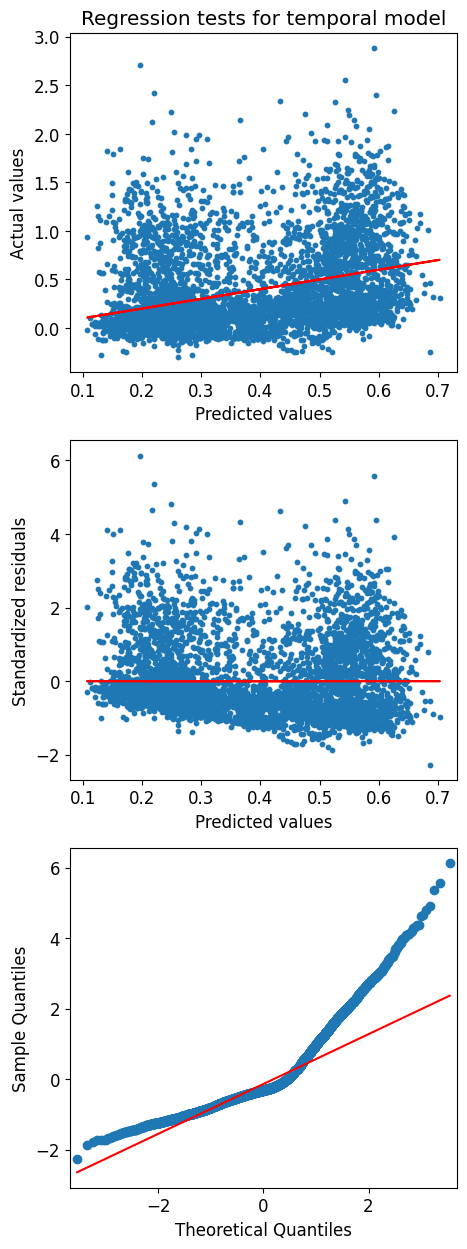

In [323]:
mod = smf.gls(formula='log(normed_vert_vel)~ environment + time + cos_horizontal_dir_avg + log(horizontal_speed_avg) +  sin_horizontal_dir_avg', data=alltemporal)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})
mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15), rasterized=True)


slope, intercept = np.polyfit(res.fittedvalues, log(alltemporal.normed_vert_vel), 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('Regression tests for temporal model')
ax[0].scatter(res.fittedvalues, log(alltemporal.normed_vert_vel), s=10)
ax[0].plot(res.fittedvalues, abline_values, 'r')
ax[0].set_xlabel ('Predicted values')
ax[0].set_ylabel ('Actual values')
#ax[0].set_xlim(-5,90)
#ax[0].set_ylim(-5,90)

slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10)
ax[1].plot(res.fittedvalues, abline_values, 'r')
ax[1].set_xlabel ('Predicted values')
ax[1].set_ylabel ('Standardized residuals')


sm.qqplot(res.resid_pearson, line='q', ax=ax[2])
plt.show()

fig.savefig('regressionresidualtests_vertical.svg', format='svg')
